# Faster R-CNN

In [2]:
# prompt: mount the drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# --- Cell -1: Installations (if needed) ---
# Upgrade pip (optional)
!pip install --upgrade pip

# Install PyTorch and torchvision (usually pre-installed in Colab)
!pip install torch torchvision

# Install OpenCV (if not already available)
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [14]:
# --- Cell 0: All Imports ---
# Importing all required libraries once. This prevents repeated imports in later cells.
# These libraries support image processing, dataset handling, model creation, and training.

import os                      # For file and directory operations
import cv2                     # For reading and processing images
import torch                   # PyTorch core library
import numpy as np             # For numerical operations
import torchvision             # For pre-trained models and transforms
import torch.optim as optim    # For setting up the optimizer
import torchvision.transforms.functional as TF  # For image-to-tensor conversion
from torch.utils.data import Dataset, DataLoader  # For creating custom datasets and loaders
from torch.utils.data import Subset


In [9]:
# --- Cell 1: Dataset and Collate Function ---
# This cell defines a custom Dataset class (YOLODataset) to load images and their YOLO-format labels.
# It also includes a collate function to handle batches of images with variable numbers of objects.

class YOLODataset(Dataset):
    """
    Custom Dataset for reading images and YOLO-format label files.

    Why?
    - Faster R-CNN requires annotations with bounding boxes and class labels.
    - YOLO format provides normalized coordinates that we convert to absolute pixel values.

    How?
    - For each image, we locate the corresponding .txt file with annotations.
    - We convert each annotation from <class_id> <x_center> <y_center> <width> <height>
      (with normalized values) to absolute [xmin, ymin, xmax, ymax] coordinates.
    """
    def __init__(self, images_dir, labels_dir, transforms=None):
        """
        Args:
            images_dir (str): Directory with image files.
            labels_dir (str): Directory with corresponding YOLO label files.
            transforms (callable, optional): Transformations to apply to the images.
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms

        # List images ending with .jpg or .png.
        self.images = [f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        # Returns the total number of images.
        return len(self.images)

    def __getitem__(self, idx):
        # --- Load the Image ---
        img_filename = self.images[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        img = cv2.imread(img_path)  # Read image using OpenCV.
        if img is None:
            raise RuntimeError(f"Image not found: {img_path}")
        # Convert image from BGR (OpenCV default) to RGB.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape  # Get dimensions for scaling labels.

        # --- Load the Labels ---
        # Assumes label file has the same base name as the image with a .txt extension.
        label_filename = os.path.splitext(img_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)
        boxes = []   # Will store bounding box coordinates.
        labels = []  # Will store class labels.
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue  # Skip lines not matching the YOLO format.
                # YOLO format: class_id, x_center, y_center, width, height (all normalized)
                class_id = int(parts[0])
                x_center, y_center, w, h = map(float, parts[1:])
                # Convert normalized values to absolute pixel coordinates.
                x_center *= width
                y_center *= height
                w *= width
                h *= height
                xmin = x_center - w / 2
                ymin = y_center - h / 2
                xmax = x_center + w / 2
                ymax = y_center + h / 2
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id)
        else:
            # If no label file exists, return empty lists.
            boxes = []
            labels = []

        # --- Prepare the Target Dictionary ---
        # The model expects targets to be a dictionary with specific keys.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,               # Bounding boxes in [xmin, ymin, xmax, ymax] format.
            "labels": labels,             # Class labels.
            "image_id": torch.tensor([idx])  # Unique image identifier.
        }
        # Calculate area for each bounding box (needed by the model).
        if boxes.numel() > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])
        target["area"] = area
        # Assume that no objects are crowd instances.
        target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # --- Apply Transforms ---
        if self.transforms:
            img = self.transforms(img)
        else:
            # Convert the image to a tensor with values normalized to [0, 1].
            img = TF.to_tensor(img)

        return img, target

def collate_fn(batch):
    """
    Custom collate function.

    Why?
    - When batching images, each image may have a different number of objects.
    - This function organizes a batch into two lists: one for images and one for targets.

    Output:
    - A tuple (list_of_images, list_of_target_dictionaries).
    """
    return tuple(zip(*batch))


In [12]:
# --- Cell 2: Model Setup ---
# This cell sets up the Faster R-CNN model using a pre-trained ResNet-50 backbone.
# We then customize the classification head to match the number of classes in our dataset.

def get_model(num_classes):
    """
    Loads a pre-trained Faster R-CNN model and adjusts the final classifier head.

    Why?
    - Using a pre-trained model allows leveraging learned features.
    - We replace the head to adapt it to the number of classes in our dataset.

    Args:
        num_classes (int): Number of classes (including background).

    How?
    - The pre-trained model is loaded.
    - The number of input features for the classifier is determined.
    - The head is replaced with a new predictor that outputs the correct number of classes.

    Output:
    - A Faster R-CNN model ready for training on your dataset.
    """
    # Load a pre-trained Faster R-CNN model with a ResNet-50-FPN backbone.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classification head.
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the classifier with a new one that has the desired number of classes.
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

# Optional quick test:
# Uncomment these lines to check the model structure.
#num_classes = 2  # For example: 1 object class + background.
#model = get_model(num_classes)
#print(model)


In [15]:
# --- Cell 3: Training Loop ---
# This cell sets up the training loop, including data loaders, optimizer, and learning rate scheduler.
# It then iterates over epochs, processing each batch, computing the loss, and updating model weights.

# --- Define Paths ---
# Adjust these paths to point to your training and validation image/label directories.
train_images = "/content/drive/MyDrive/AWAS_Master/Andreas_div/R-CNN Testing/Train_val_split_awas_images_only_for_testing/train_new_split_redefined_bb_kept_edges_bb_over_hidden_parts_not_augmented/images"
train_labels = "/content/drive/MyDrive/AWAS_Master/Andreas_div/R-CNN Testing/Train_val_split_awas_images_only_for_testing/train_new_split_redefined_bb_kept_edges_bb_over_hidden_parts_not_augmented/labels"

val_images = "/content/drive/MyDrive/AWAS_Master/Andreas_div/R-CNN Testing/Train_val_split_awas_images_only_for_testing/val_new_split_redefined_bb_kept_edges_bb_over_hidden_parts_not_augmented/images"
val_labels = "/content/drive/MyDrive/AWAS_Master/Andreas_div/R-CNN Testing/Train_val_split_awas_images_only_for_testing/val_new_split_redefined_bb_kept_edges_bb_over_hidden_parts_not_augmented/labels"

# --- Create Datasets ---
# We use the YOLODataset defined earlier to read images and annotations.
train_dataset = YOLODataset(train_images, train_labels)
val_dataset = YOLODataset(val_images, val_labels)

############################################ For testing
train_subset = Subset(train_dataset, list(range(1, 10)))
val_subset = Subset(val_dataset, list(range(1, 10)))
###############################################
# --- Create DataLoaders ---
# The DataLoader handles batching. The custom collate_fn makes sure batches are properly formed.
train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# --- Initialize the Model ---
# Define the number of classes (for example, 2 = 1 object class + background).
num_classes = 8
model = get_model(num_classes)
# Move the model to GPU if available.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# --- Set up the Optimizer and Learning Rate Scheduler ---
# We use SGD with momentum for optimization.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# The scheduler decreases the learning rate every few epochs.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# --- Training Loop ---
# For each epoch, we process batches of images, compute losses, backpropagate, and update weights.
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set model to training mode.
    epoch_loss = 0.0
    for images, targets in train_loader:
        # Move images and targets to the device (GPU or CPU).
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        # Forward pass: The model returns a dictionary of losses.
        loss_dict = model(images, targets)
        # Sum all the losses.
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass: Compute gradients and update weights.
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Update the learning rate.
    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

# --- Simple Evaluation on Validation Data ---
# Switch to evaluation mode to disable dropout and batch norm updates.
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        # Move images to device.
        images = [img.to(device) for img in images]
        # The model returns predictions (bounding boxes, labels, and scores).
        outputs = model(images)
        print("Sample validation predictions:", outputs)
        break  # Process only one batch for demonstration


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 Loss: 5.7618
Epoch 2/10 Loss: 3.3442
Epoch 3/10 Loss: 3.0398
Epoch 4/10 Loss: 2.5220
Epoch 5/10 Loss: 2.7281
Epoch 6/10 Loss: 2.8672
Epoch 7/10 Loss: 2.5048
Epoch 8/10 Loss: 2.6680
Epoch 9/10 Loss: 2.4719
Epoch 10/10 Loss: 2.3828
Sample validation predictions: [{'boxes': tensor([[ 229.0291,  784.5038,  385.7314,  950.6244],
        [  20.6744,  116.9402,  146.3801,  315.4021],
        [ 251.1447,  793.8786,  406.4822,  952.8152],
        [ 245.3461,  839.5896,  343.1402,  959.9111],
        [1045.8322,    3.4005, 1095.4291,  123.2321],
        [  16.1451,  110.0859,  144.0656,  309.9066],
        [ 241.1371,  833.7486,  346.9483,  958.7030],
        [ 246.3406,  792.8805,  404.3714,  958.0901],
        [  10.8646,  150.0258,  157.1844,  333.8424],
        [1044.8464,    1.7346, 1093.1101,  125.7396],
        [ 238.7325,  837.2405,  345.8720,  960.0001],
        [  32.5782,  194.1245,  178.2393,  346.0143],
        [ 254.6669,  856.2557,  375.4880,  924.6377],
        [ 243.2

In [16]:
# --- Cell 5: Output Interpretation and Visualization Module ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, prediction, class_names=None, score_threshold=0.5):
    """
    Visualizes the predictions for a single image by drawing bounding boxes and labels.

    Args:
        image (torch.Tensor or np.ndarray): The image on which to overlay predictions.
            - If a torch.Tensor, it should be in [C, H, W] format.
        prediction (dict): Prediction output for the image containing:
            - 'boxes': Tensor of shape (num_boxes, 4) with [xmin, ymin, xmax, ymax].
            - 'labels': Tensor of shape (num_boxes,) with predicted class indices.
            - 'scores': Tensor of shape (num_boxes,) with confidence scores.
        class_names (list or dict, optional): A mapping from class indices to human-readable names.
        score_threshold (float): Only predictions with scores above this threshold will be shown.

    How it works:
        - Converts the image to a displayable format if necessary.
        - Iterates over each predicted bounding box.
        - Filters out predictions below the score threshold.
        - Draws a rectangle and label text (with class name and score) on the image.

    Output:
        - Displays the image with overlaid bounding boxes using matplotlib.
    """
    # Convert image to numpy if it is a torch tensor
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
    # If the image has float values in [0,1], convert it to [0,255]
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Create a matplotlib figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Retrieve prediction components and move them to CPU as numpy arrays
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Loop over each prediction
    for box, label, score in zip(boxes, labels, scores):
        # Only display predictions with a score above the threshold
        if score < score_threshold:
            continue
        xmin, ymin, xmax, ymax = box
        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # Prepare label text: if class_names are provided, use them
        if class_names is not None and label < len(class_names):
            label_text = f"{class_names[label]}: {score:.2f}"
        else:
            label_text = f"Class {label}: {score:.2f}"
        # Place the text above the bounding box
        ax.text(xmin, ymin, label_text, color='yellow', fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

def interpret_predictions_summary(predictions, score_threshold=0.5):
    """
    Prints a summary for each image's predictions in a batch.

    Args:
        predictions (list of dict): List of prediction dictionaries (one per image).
            Each dictionary contains 'boxes', 'labels', and 'scores'.
        score_threshold (float): Only consider predictions with scores above this threshold.

    How it works:
        - For each image, it counts the number of detections with scores above the threshold.
        - It calculates the average score of these detections.
        - Prints a simple summary for each image.

    Output:
        - Prints the number of detections and average score for each image.
    """
    for idx, pred in enumerate(predictions):
        boxes = pred['boxes'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        # Filter predictions by score threshold
        valid = scores >= score_threshold
        num_detections = valid.sum()
        avg_score = scores[valid].mean() if num_detections > 0 else 0.0
        print(f"Image {idx}: {num_detections} detections, average score: {avg_score:.2f}")


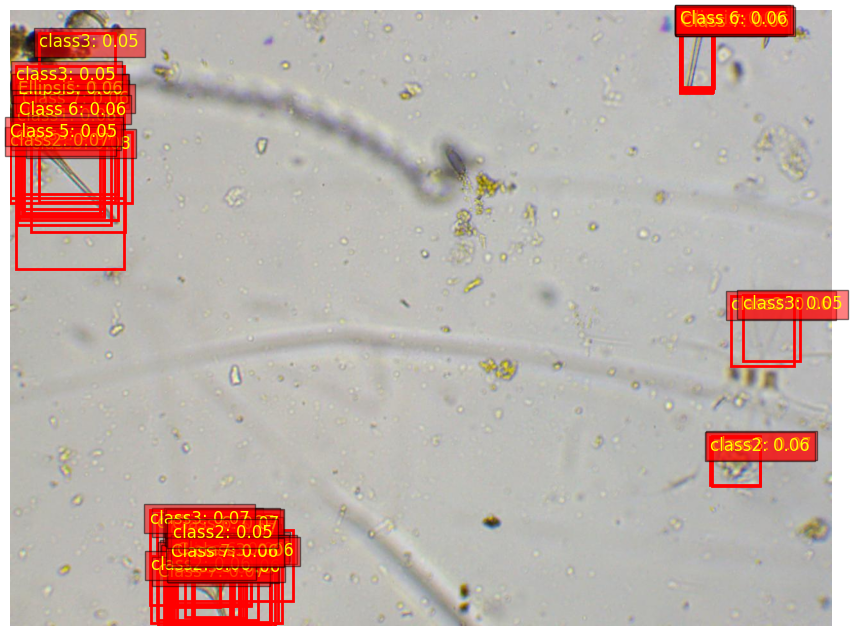

In [20]:
visualize_predictions(images[0], outputs[0], class_names=["background", "class1", "class2", "class3", ...], score_threshold=0.01)